In [1]:
from src.simulator import Simulator
from src.parameters import ModelParameters, MPCParameters
from src.controller import MPC
from src.plotter import Plotter

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import threading
from tqdm import tqdm
%config InlineBackend.figure_formats = ['svg']

In [3]:
m1 = 0.5
m2 = 0.5
L1 = 0.5
L2 = 0.5
l2 = 0.5*L2
l1 = 0.5*L1
I1 = m1*l1**2
I2 = m2*l2**2
f1 = 0.1
f2 = 0.1

model_params_sim = ModelParameters

model_params_sim.m1 = m1
model_params_sim.m2 = m2
model_params_sim.L1 = L1
model_params_sim.L2 = L2
model_params_sim.l1 = l2
model_params_sim.l2 = l1
model_params_sim.I1 = I1
model_params_sim.I2 = I2
model_params_sim.f1 = f1
model_params_sim.f2 = f2

In [4]:
sim = Simulator(dt=0.05)
sim.set_model_params(model_parameters=model_params_sim)

In [5]:
mpc_params = MPCParameters

# TODO TIMESTEPs with constant time 10s horizon not 50 steps with XY dt

mpc_params.N = 50
mpc_params.dt = 0.05
mpc_params.u_lim = 4
mpc_params.max_iter = 100

# Same model for simulator and controller
model_params_mpc = model_params_sim

mpc = MPC()
mpc.set_controller_params(controller_parameters=mpc_params)
mpc.set_model_params(model_parameters=model_params_mpc)

x0 = [0, 0, 0.25, 0]
steps = 300

x_sim = np.ndarray((steps, 4))
x_sim[0] = x0

u_sim = np.ndarray(steps-1)
J_sim = np.ndarray(steps-1)
E_kin_sim = np.ndarray(steps-1)
E_pot_sim = np.ndarray(steps-1)


for i in tqdm(range(steps-1)):
  
  model, feas, xOpt, uOpt, JOpt = mpc.solve_cftoc(x_sim[i])
  u = uOpt[0,0]
  
  u_sim[i] = u
  J_sim[i] = JOpt
  E_kin_sim[i], E_pot_sim[i] = sim.calculate_energies(x_sim[i])
  
  x_sim[i+1] = sim.simulate_step(x=x_sim[i], u=u)

  6%|▋         | 19/299 [00:06<01:39,  2.80it/s]


KeyboardInterrupt: 

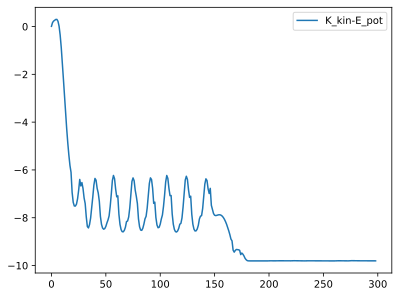

In [ ]:
# plt.plot(E_kin_sim, label='E_kin')
# plt.plot(E_pot_sim, label='E_pot')
plt.plot(E_kin_sim-E_pot_sim, label='JK_kin-E_pot')
plt.legend()
plt.show()

# Parameter Studies

In [51]:
def simulate(steps=300, x0=[0, 0, 0.25, 0], N=2.5, dt=0.05, u_lim=4, max_iter=100):
  mpc_params = MPCParameters

  mpc_params.N = int(np.round(N/dt))   # horizon in time domain
  mpc_params.dt = dt
  mpc_params.u_lim = u_lim
  mpc_params.max_iter = max_iter

  # Same model for simulator and controller
  model_params_mpc = model_params_sim

  mpc = MPC()
  mpc.set_controller_params(controller_parameters=mpc_params)
  mpc.set_model_params(model_parameters=model_params_mpc)

  x_sim = np.ndarray((steps, 4))
  x_sim[0] = x0

  u_sim = np.ndarray(steps-1)
  J_sim = np.ndarray(steps-1)
  E_kin_sim = np.ndarray(steps-1)
  E_pot_sim = np.ndarray(steps-1)


  for i in tqdm(range(steps-1)):

    model, feas, xOpt, uOpt, JOpt = mpc.solve_cftoc(x_sim[i])
    u = uOpt[0,0]
    u_sim[i] = u
    J_sim[i] = JOpt
    E_kin_sim[i], E_pot_sim[i] = sim.calculate_energies(x_sim[i])

    x_sim[i+1] = sim.simulate_step(x=x_sim[i], u=u)

  return x_sim, u_sim, J_sim

## Horizon


In [82]:
# N_values = [0.05, 0.1, 1, 10]
N_values = [0.05, 0.1, 0.25, 0.5, 0.75, 1.0]

J_sim_results = []
x_sim_results = []

for i, N in enumerate(N_values):
  print('Calculating for N={}s'.format(N))
  x_sim, u_sim, J_sim = simulate(N=N)
  J_sim_results.append(J_sim)
  x_sim_results.append(x_sim)

Calculating for N=0.05s


100%|██████████| 299/299 [00:06<00:00, 47.28it/s]


Calculating for N=0.1s


100%|██████████| 299/299 [00:07<00:00, 42.16it/s]


Calculating for N=0.25s


100%|██████████| 299/299 [00:10<00:00, 29.10it/s]


Calculating for N=0.5s


100%|██████████| 299/299 [00:27<00:00, 10.97it/s]


Calculating for N=0.75s


100%|██████████| 299/299 [00:43<00:00,  6.84it/s]


Calculating for N=1.0s


100%|██████████| 299/299 [00:28<00:00, 10.63it/s]


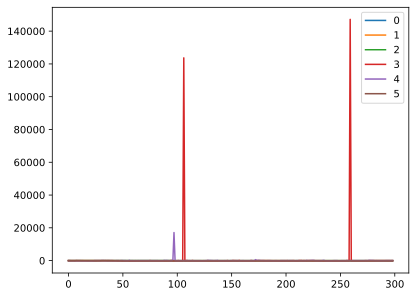

In [88]:
for i, J in enumerate(J_sim_results):
  plt.plot(J, label=i)

plt.legend()

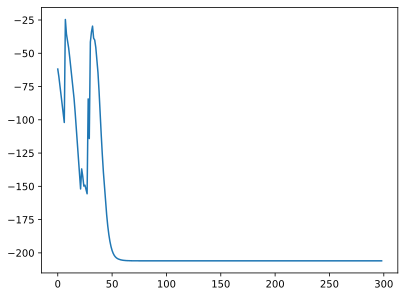

In [91]:
plt.plot(J_sim_results[5])

In [92]:
plotter = Plotter
anim = plotter.animate_pendulum(x_sim_results[5][:,0], x_sim_results[5][:,1], model_params_sim.L1, model_params_sim.L2, dt=0.05)
anim

# Plot

In [ ]:
plotter = Plotter
anim = plotter.animate_pendulum(x_sim[:,0], x_sim[:,1], model_params_sim.L1, model_params_sim.L2, dt=0.05)
anim

In [ ]:
# f = r"results/animations/animation.gif" 

# anim.save(f, writer='imagemagick', fps=20)

MovieWriter imagemagick unavailable; using Pillow instead.
